# Accelerating a discrete 2d convolution using FFT

In [1]:
from utils import *
np.random.seed(42)

## Introduction
Fast Fourier Transform (FFT) can significantly accelerate 2D convolution, making it ideal for handling large convolutional filters and input images. This notebook explores the theory and implementation of FFT-based 2D convolution, demonstrating its speed and efficiency compared to direct convolution.

## Theory
Fast Fourier Transform (FFT) can be used to accelerate 2D convolution through a FFT-based convolution. This approach is particularly useful when dealing with large convolutional filters or when you need to perform convolution on large input images.

The idea behind using FFT for convolution is to transform both the input image and the convolutional kernel from the spatial domain to the frequency domain using FFT. In the frequency domain, convolution becomes a simple element-wise multiplication operation, which is much faster to compute than traditional spatial convolution.

FFT-based convolution can be significantly faster for large convolutional filters and input images, as the FFT algorithm itself has a complexity of $\mathcal{O}(N \log N)$, which is often faster than the $\mathcal{O}(N^2)$ complexity of spatial convolution for large $N$.

FFT-based 2D convolution leverages the [Convolution Theorem](https://en.wikipedia.org/wiki/Convolution_theorem), which states that convolution in the spatial domain is equivalent to element-wise multiplication in the frequency (Fourier) domain. This theorem is fundamental to understanding the mathematics behind FFT-based convolution.

## Creation of the input signal: $f$

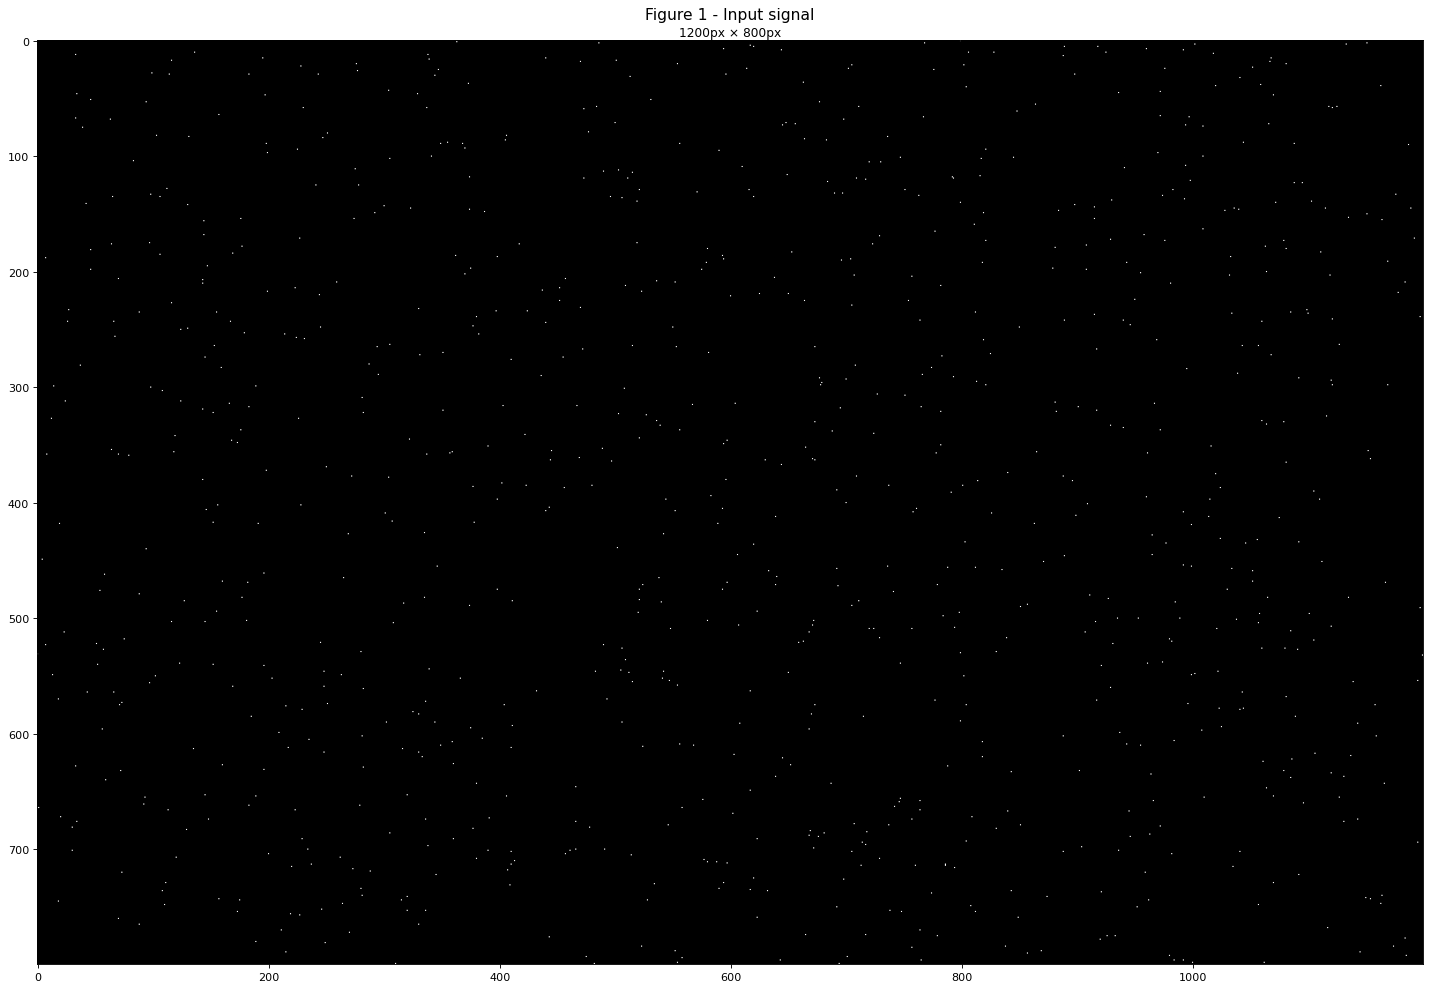

In [2]:
W, H = 1200, 800
f = np.random.rand(W, H)
f[f < .999] = 0

display_picture(f.T, f"Input signal", f"{W}px × {H}px")

## Creation of the kernel: $g$

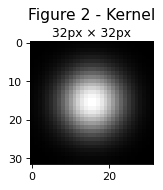

In [3]:
M, N = 32, 32
X, Y = np.mgrid[-1:1:M*1j, -1:1:N*1j]
g = np.exp(-X ** 2 * 2 - Y ** 2 * 2) ** 2

display_picture(g.T, f"Kernel", f"{M}px × {N}px", figure_size=(2, 2))

## Definition of the direct 2d convolution

In the spatial domain, convolution between two signals (or images) $f$ and $g$ is defined as:
$$ \large \displaystyle \left(f * g\right)(x, y) = \sum_{m=-\infty}^{\infty} \sum_{n=-\infty}^{\infty} f(m, n) \cdot g(x-m, y-n) $$
where $(x, y)$ are the are the coordinates in the output image, and $(m, n)$ are the coordinates in the kernel $g$.

In [4]:
def direct_2d_convolution(input_matrix, kernel_matrix, stride=(1, 1)):
    # Evaluation of the output shape:
    stride = np.array(stride)
    input_shape = np.array(input_matrix.shape)
    kernel_shape = np.array(kernel_matrix.shape)
    output_shape = (input_shape - kernel_shape) // stride + 1
    
    # Creation of the convolution windows:
    output_matrix_shape = (*output_shape, *kernel_shape)
    output_strides = (*np.array(input_matrix.strides) * np.array(stride), *input_matrix.strides)
    convolution_windows = np.lib.stride_tricks.as_strided(input_matrix, output_matrix_shape, output_strides)
    
    # Direct convolution on the windows:
    result = np.einsum('xymn, mn -> xy', convolution_windows, kernel_matrix, optimize=True)
    
    return result

### Result of the direct 2d convolution

In [5]:
res_direct = direct_2d_convolution(f, g)
res_direct.shape

(1169, 769)

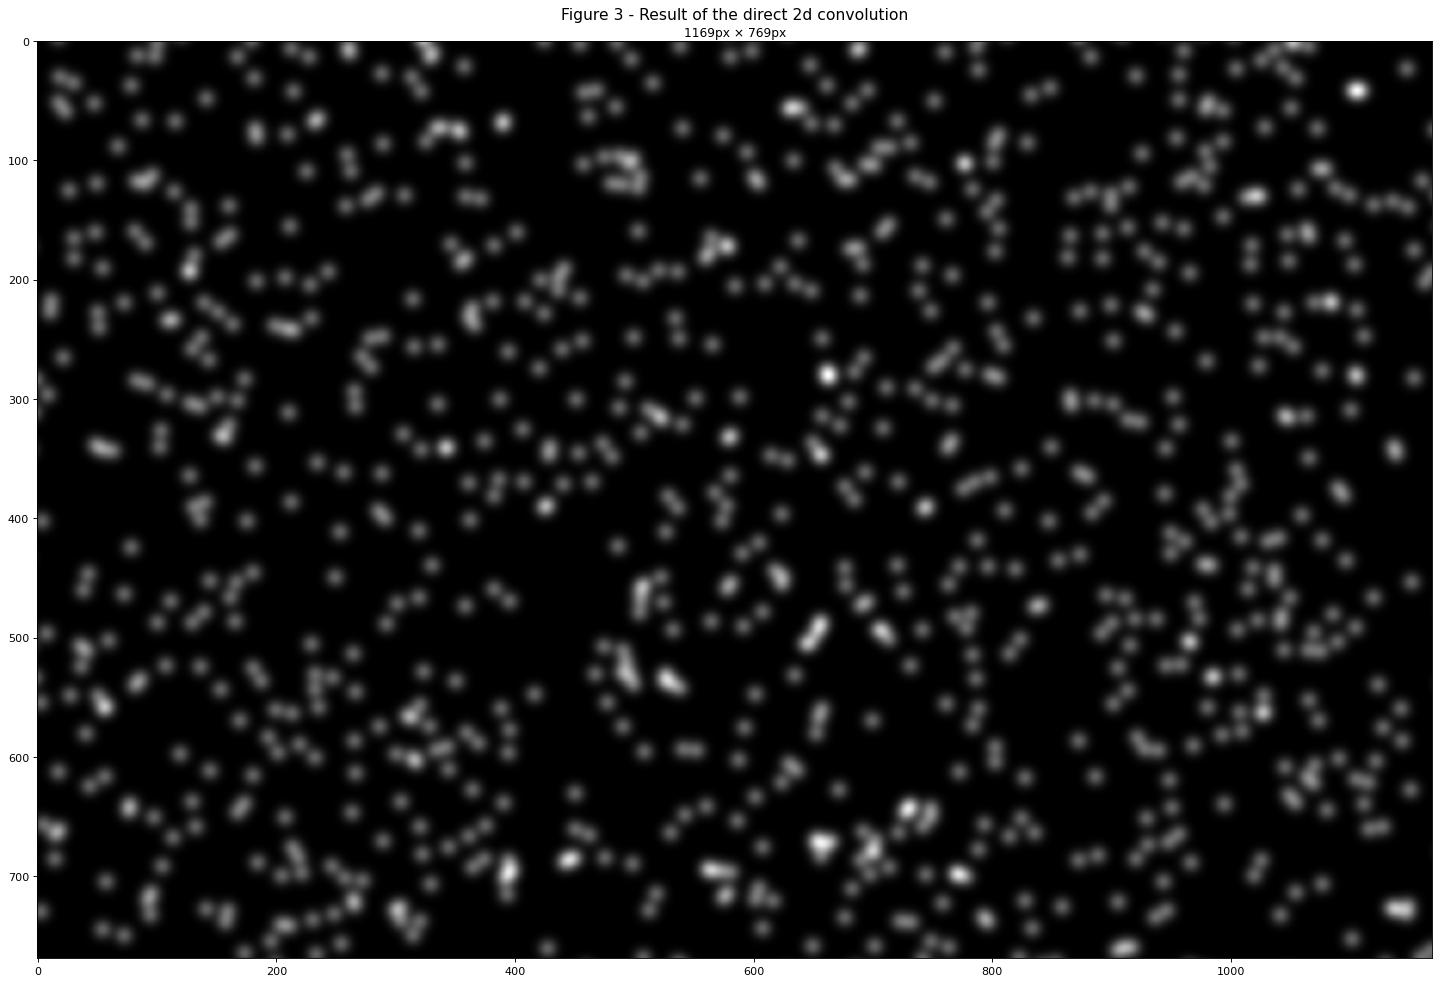

In [6]:
display_picture(res_direct.T, f"Result of the direct 2d convolution", f"{res_direct.shape[0]}px × {res_direct.shape[1]}px")

## Definition of the FFT based 2d convolution

The Convolution Theorem states that convolution in the spatial domain is equivalent to element-wise multiplication in the frequency domain. Mathematically, it can be expressed as:

$$ \large \displaystyle \mathcal{F} \left\{f * g\right\}(u, v) = \mathcal{F} \left\{f\right\}(u, v) \cdot \mathcal{F} \left\{g\right\}(u, v) $$

where $\mathcal{F}$ is the Fourrier transform and $(u, v)$ are the coordinates in the frequency domain.

To obtain a 2d convolution in the spatial domain using the Fourrier transform, we simply need to reformulate the previous equation such as:

$$ \large \displaystyle \left(f * g\right)(x, y) = \mathcal{F}^{-1} \left\{\mathcal{F} \left\{f\right\} \cdot \mathcal{F} \left\{g\right\}\right\}(x, y) $$

In [7]:
def fft_based_2d_convolution(input_matrix, kernel_matrix, stride=(1, 1)):
    input_shape = np.array(input_matrix.shape)
    kernel_shape = np.array(kernel_matrix.shape)
    
    # Evaluation of the required padding for the FFT:
    padding_height1, padding_width1 = (input_shape - kernel_shape) // 2
    padding_height2, padding_width2 = (input_shape - kernel_shape) - (padding_height1, padding_width1)
    kernel_radius_height1, kernel_radius_width1 = (kernel_shape - 1) // 2
    kernel_radius_height2, kernel_radius_width2 = (kernel_shape - 1) - (kernel_radius_height1, kernel_radius_width1)
    
    # Padding and alignment of the kernel prior to the convolution:
    padded_kernel = np.pad(kernel_matrix, ((padding_height2, padding_height1), (padding_width2, padding_width1)), mode='constant')
    shifted_kernel = np.fft.ifftshift(padded_kernel)
    
    # Convolution in the frequency domain:
    input_matrix_frequency = np.fft.fft2(input_matrix) * np.conj(np.fft.fft2(shifted_kernel))
    
    # Inverse FFT to obtain the 2d convolution in the spatial domain:
    result = np.real(np.fft.ifft2(input_matrix_frequency))[kernel_radius_height2:-kernel_radius_height1:stride[0], kernel_radius_width2:-kernel_radius_width1:stride[1]]
    
    return result

### Result of the FFT based 2d convolution

In [8]:
res_FFT = fft_based_2d_convolution(f, g)
res_FFT.shape

(1169, 769)

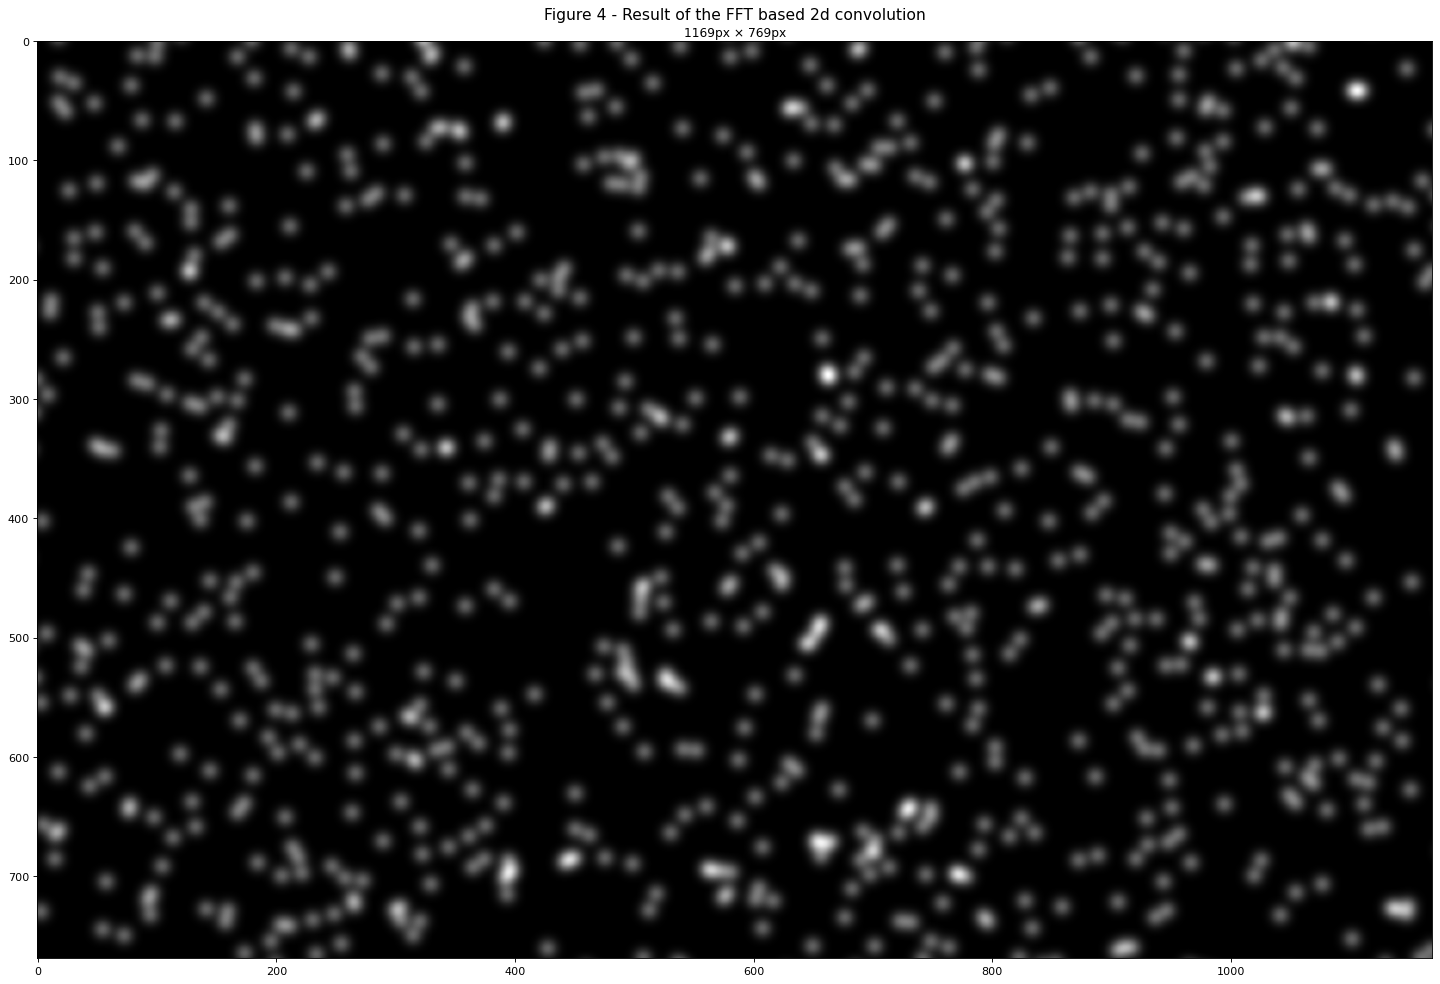

In [9]:
display_picture(res_FFT.T, f"Result of the FFT based 2d convolution", f"{res_FFT.shape[0]}px × {res_FFT.shape[1]}px")

## Comparison of the results

We can confirm that the result of both convolutions are the same up to a relative and absolute tolerance of $10^{-15}$.

In [10]:
np.testing.assert_allclose(res_direct, res_FFT, rtol=1e-15, atol=1e-15, verbose=True)

In [11]:
%timeit -n10 direct_2d_convolution(f, g, stride=(1, 1))

3.77 s ± 21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit -n10 fft_based_2d_convolution(f, g, stride=(1, 1))

39.8 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


As we can see, using the FFT is about forty to a hundred times faster than doing the direct convolution in this specific case, depending on CPU architecture.

Since the FFT method has complexity of $\mathcal{O}(N \log N)$ and the direct convolution has a complexity of $\mathcal{O}(N^2)$, we can expect even better gains for larger signal matrices or kernel matrices.

## Effect of the kernel size on the computation time

Let's explore how the kernel size affects the computation time on the previous 1200px by 800px input signal.

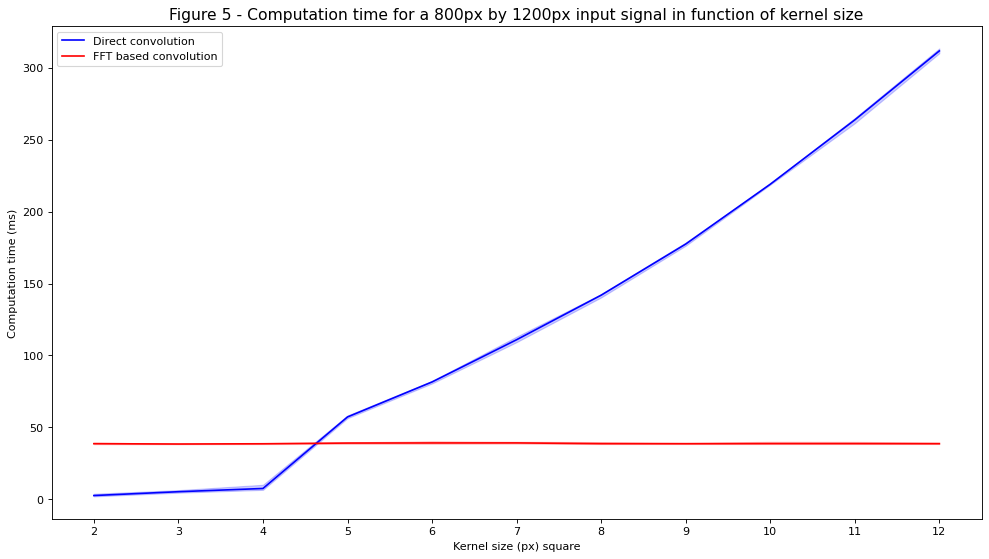

In [13]:
kernel_range = 2, 12, 1  # (Min kernel size, Max kernel size, step)
plot_computation_time_by_kernel_size(kernel_range, direct_2d_convolution, fft_based_2d_convolution, number=7, repeat=5, input_size=(H, W))

As we can see, the computation time for the FFT based convolution seems almost constant compared to the computation time for direct convolution which grows rapidly.

## Effect of the input signal size on the computation time

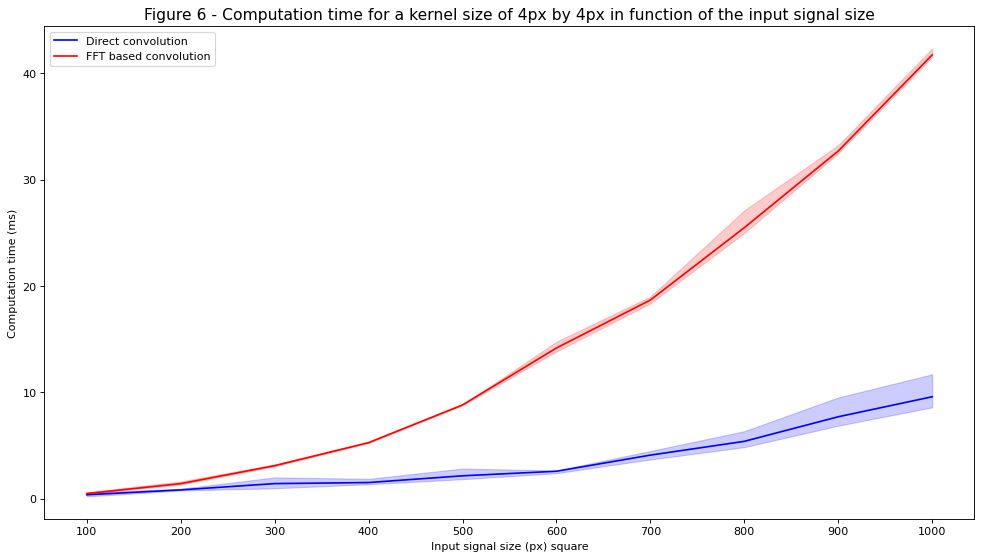

In [14]:
kernel_dim = 4
input_range = 100, 1000, 100 # (Min input size, Max input size, step)
plot_computation_time_by_input_size(input_range, direct_2d_convolution, fft_based_2d_convolution, number=7, repeat=5, kernel_size=(kernel_dim, kernel_dim))

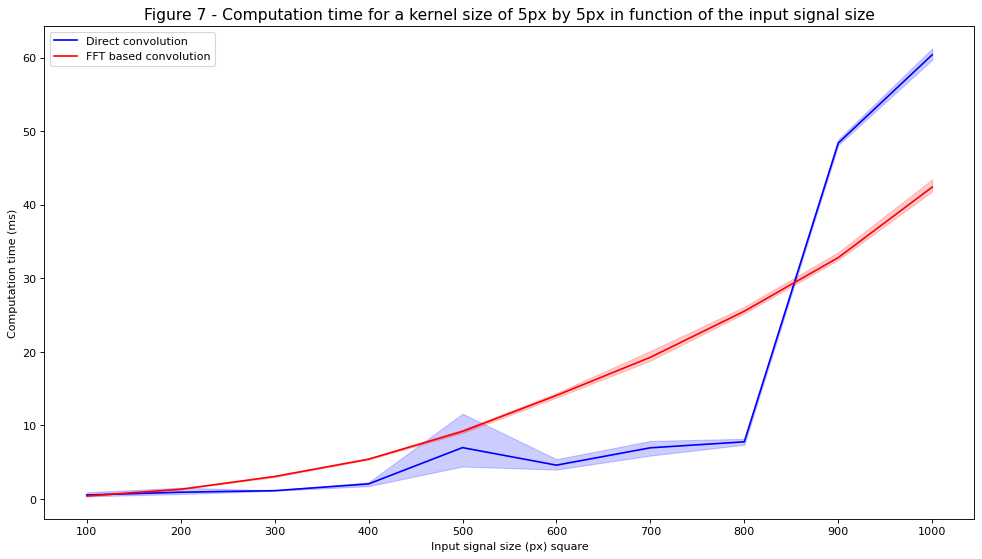

In [15]:
kernel_dim = 5
input_range = 100, 1000, 100 # (Min input size, Max input size, step)
plot_computation_time_by_input_size(input_range, direct_2d_convolution, fft_based_2d_convolution, number=7, repeat=5, kernel_size=(kernel_dim, kernel_dim))

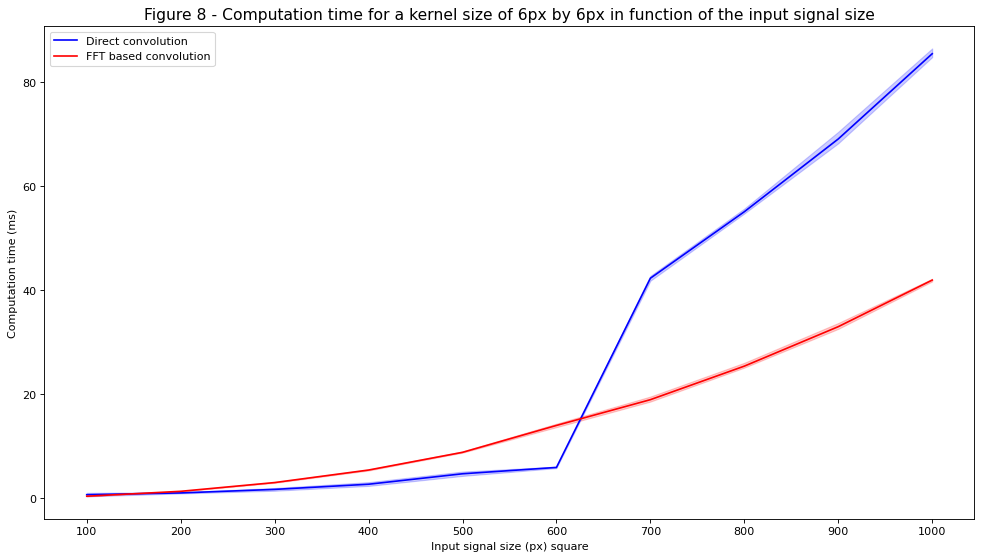

In [16]:
kernel_dim = 6
input_range = 100, 1000, 100 # (Min input size, Max input size, step)
plot_computation_time_by_input_size(input_range, direct_2d_convolution, fft_based_2d_convolution, number=7, repeat=5, kernel_size=(kernel_dim, kernel_dim))

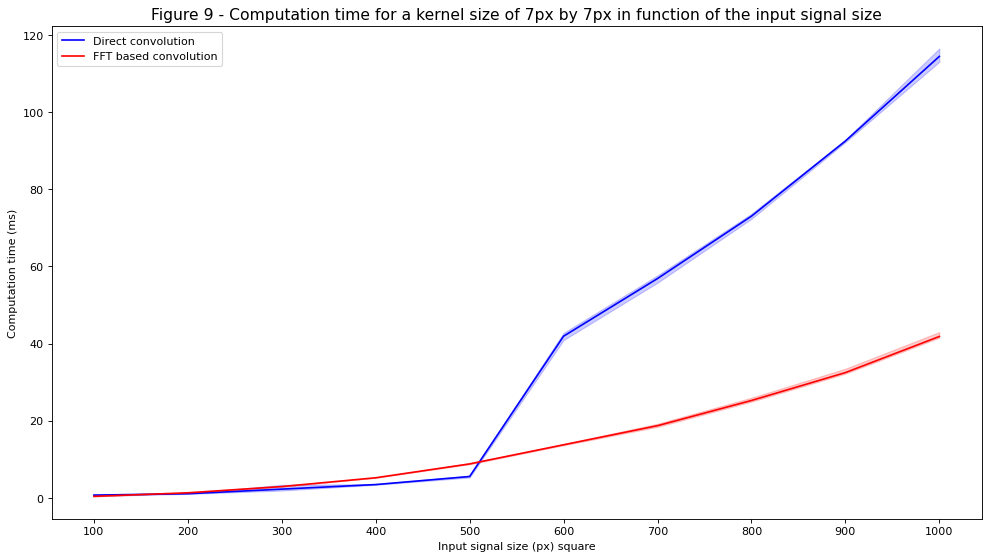

In [17]:
kernel_dim = 7
input_range = 100, 1000, 100 # (Min input size, Max input size, step)
plot_computation_time_by_input_size(input_range, direct_2d_convolution, fft_based_2d_convolution, number=7, repeat=5, kernel_size=(kernel_dim, kernel_dim))

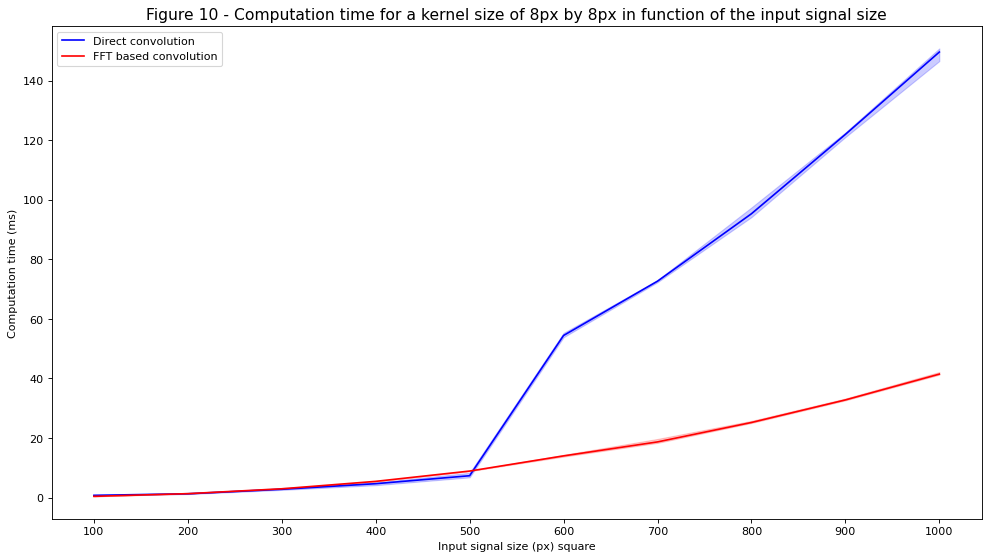

In [18]:
kernel_dim = 8
input_range = 100, 1000, 100 # (Min input size, Max input size, step)
plot_computation_time_by_input_size(input_range, direct_2d_convolution, fft_based_2d_convolution, number=7, repeat=5, kernel_size=(kernel_dim, kernel_dim))

As we can see, the divergence in efficiency happens at a kernel size of $25\mathrm{px}^2$ and for input signal size approximately respecting the following equation:
$$\sqrt{h \times w} = 400 \left(\frac{\sqrt{m \times n} - 3}{\sqrt{m \times n} - 4}\right)$$
where $(h, w)$ are the dimensions of the input signal, in pixels, and $(m, n)$ are the dimensions of the kernel, in pixels.

Before this turning point, Using the direct convolution is either faster or about as fast as the FFT based convolution. After this turning point, it is better to use the FFT based convolution.

## Conclusion
FFT-based 2D convolution is a powerful technique for accelerating convolution operations, especially for large input images and kernels. It leverages the Convolution Theorem to transform convolution into a fast element-wise multiplication in the frequency domain. This notebook demonstrated its efficiency compared to direct convolution, showcasing its potential for various signal processing and image analysis tasks.

In practice, FFT-based convolution offers significant speed gains for large input images and kernels, making it a valuable tool in computational applications.

Feel free to run your own experiments and explore the benefits of FFT-based convolution further.

### Author

This notebook was composed by René Chenard, a computer scientist and mathematician with a degree from Université Laval.

You can contact the author at: [rene.chenard.1@ulaval.ca](mailto:rene.chenard.1@ulaval.ca)